# Determining Restaurant Cost

In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc,mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import regex as re

In [154]:
df_train=pd.read_excel('C:\\Users\\User\\Downloads\\Untitled Folder\\Data_Train.xlsx')
df_train.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [150]:
df_train.isna().sum()
df_train.TITLE.nunique()

113

Imputing is required

In [155]:
# Changing the city to max repeating one.
print(df_train['CITY'].mode()[0])
df_train['CITY']=df_train['CITY'].fillna(df_train['CITY'].mode()[0])
# Changing the locality to max repeating one in Chennai
print(df_train[df_train['CITY']=='Chennai']['LOCALITY'].mode()[0])
df_train['LOCALITY']=df_train['LOCALITY'].fillna(df_train[df_train['CITY']=='Chennai']['LOCALITY'].mode()[0])
# Dropping the NA  Ratings
df_train.dropna(subset=['RATING'],inplace=True)
df_train['RATING'].replace({'NEW':'0','-':'0'},inplace=True)
df_train['RATING']=df_train['RATING'].apply(lambda x: float(x))
# Converting votes to float and replacing null with mean votes
df_train['VOTES'].fillna('0',inplace=True)
df_train['VOTES']=df_train['VOTES'].apply(lambda x: float(re.findall('[0-9]+',x)[0]))
df_train['VOTES'].replace({0:math.ceil(df_train['VOTES'].mean())},inplace=True)
# Replacing None title with mode title
df_train['TITLE'].replace({'None':df_train['TITLE'].mode()[0]},inplace=True)

Chennai
T. Nagar


In [114]:
df_train.info()
df_train.CITY.nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12688 entries, 0 to 12689
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TITLE          12688 non-null  object 
 1   RESTAURANT_ID  12688 non-null  int64  
 2   CUISINES       12688 non-null  object 
 3   TIME           12688 non-null  object 
 4   CITY           12688 non-null  object 
 5   LOCALITY       12688 non-null  object 
 6   RATING         12688 non-null  float64
 7   VOTES          12688 non-null  float64
 8   COST           12688 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 991.2+ KB


359

Exploratory Data Analysis

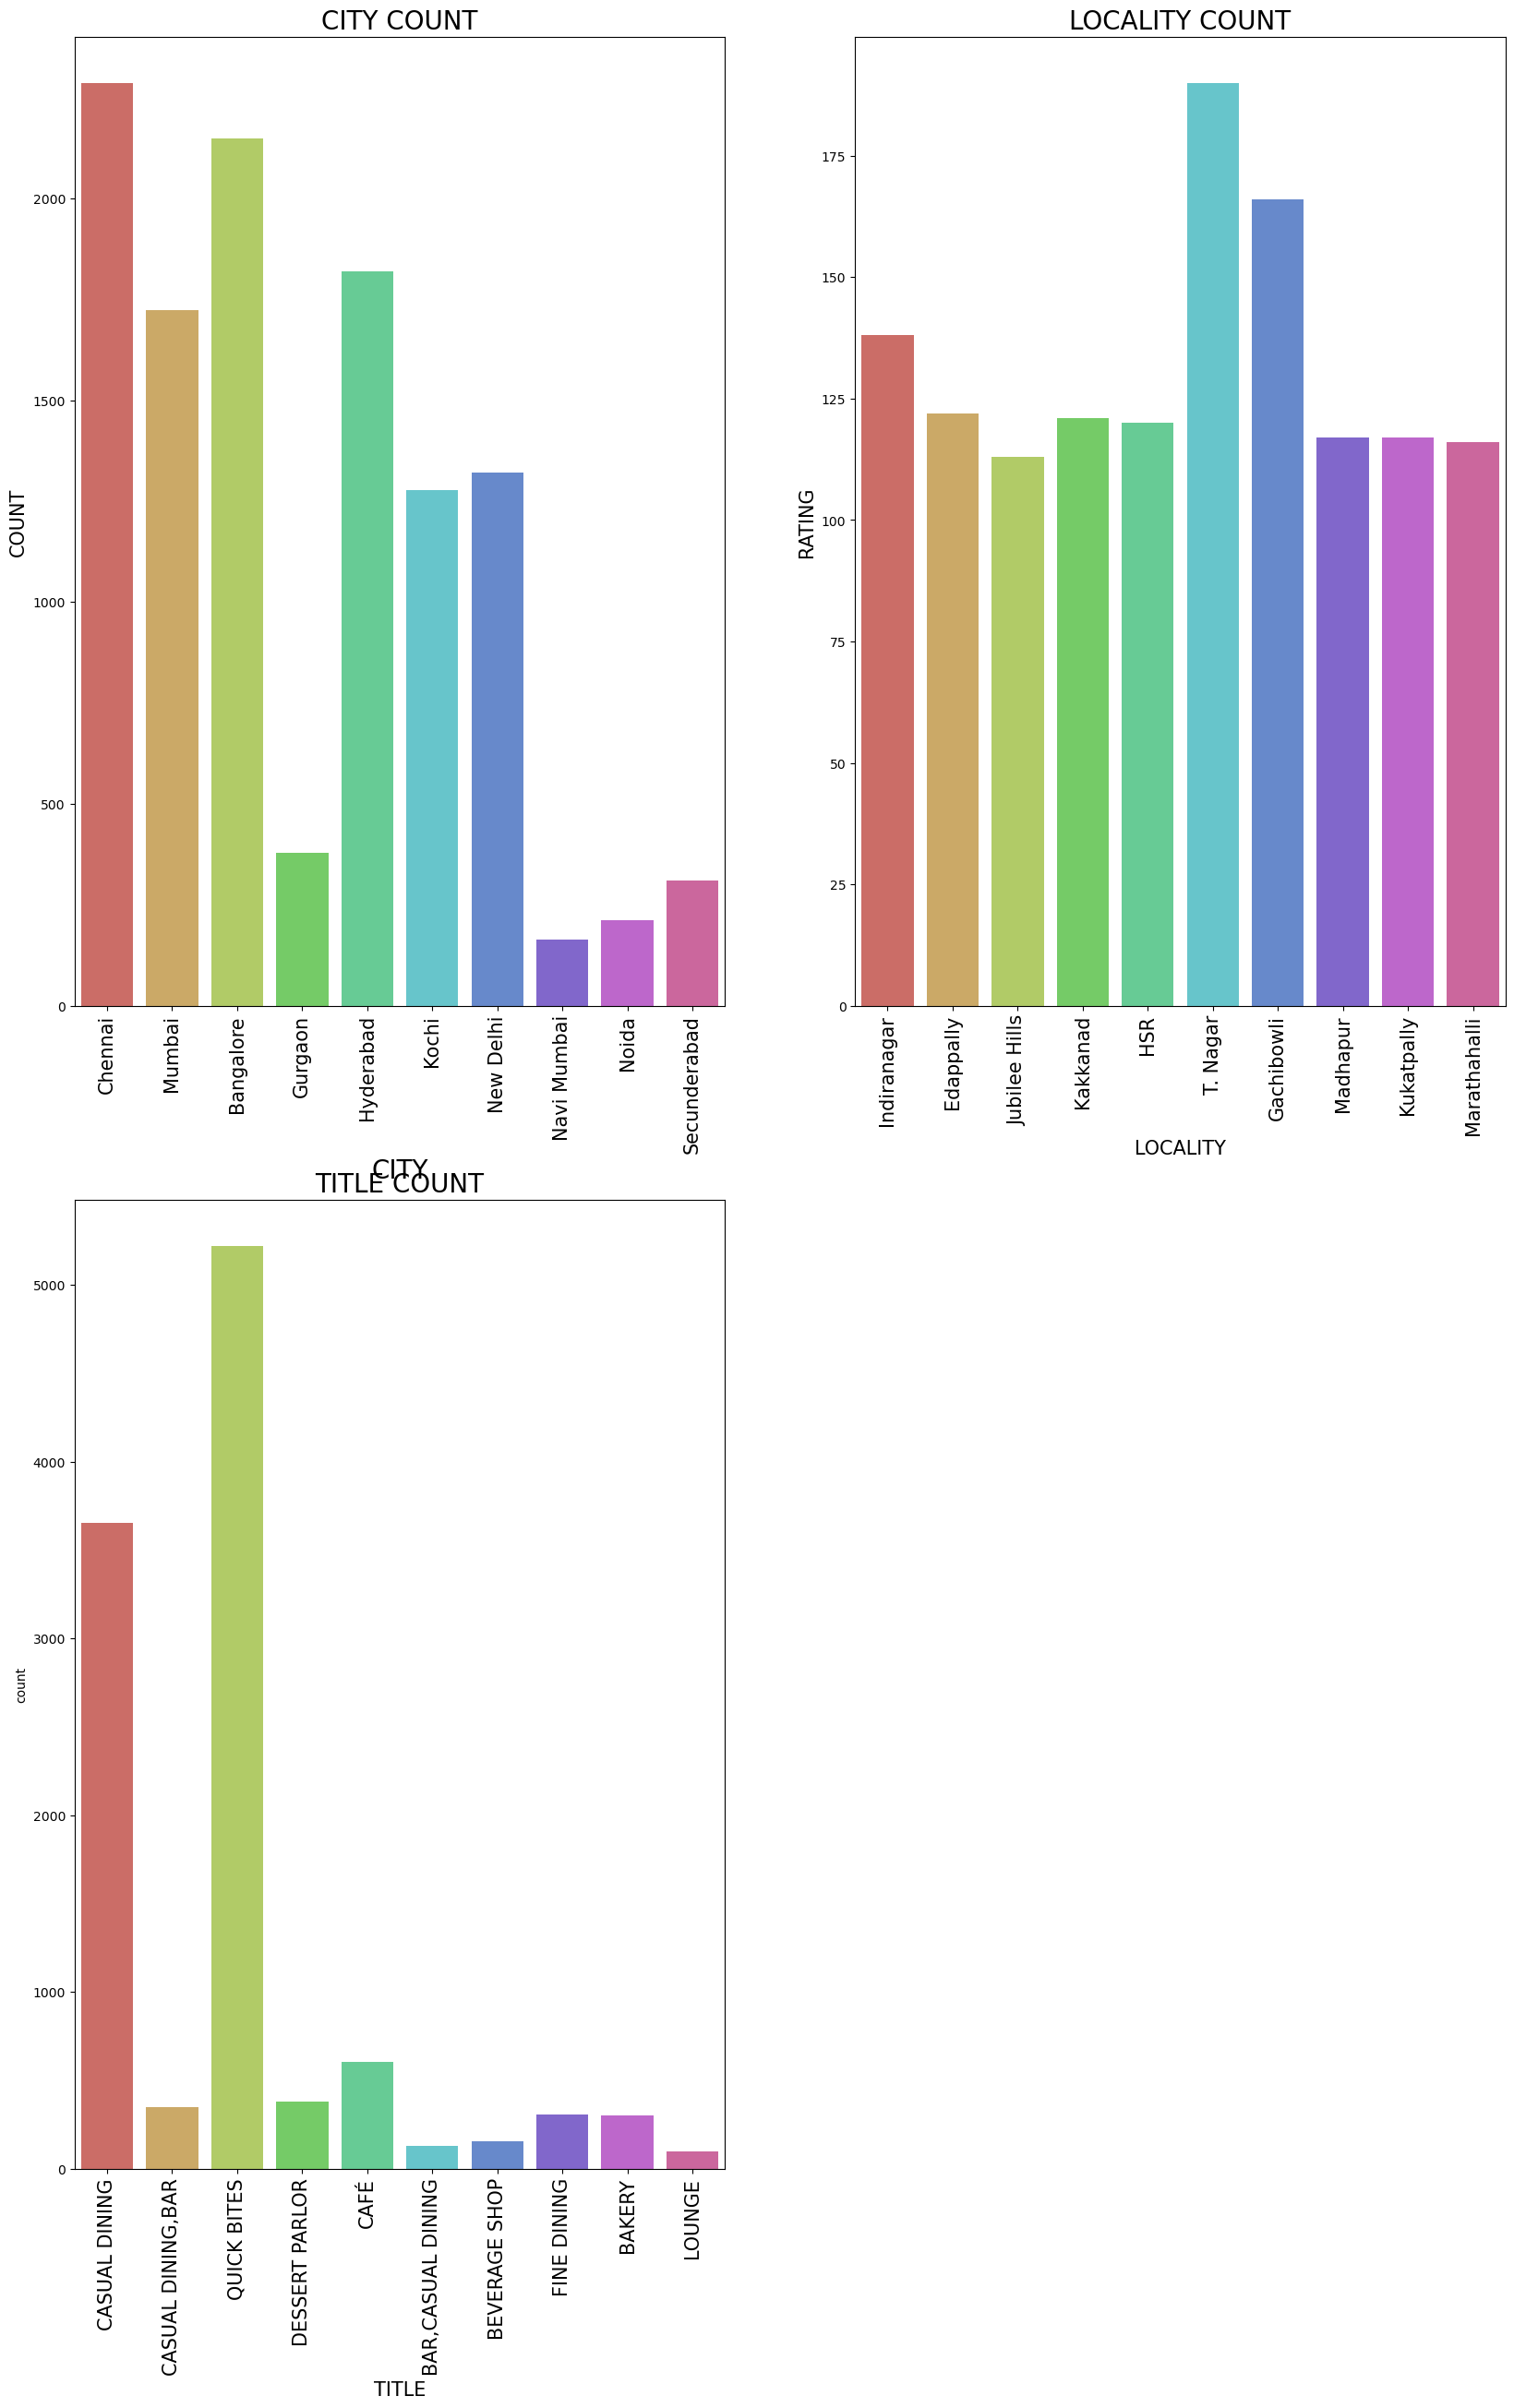

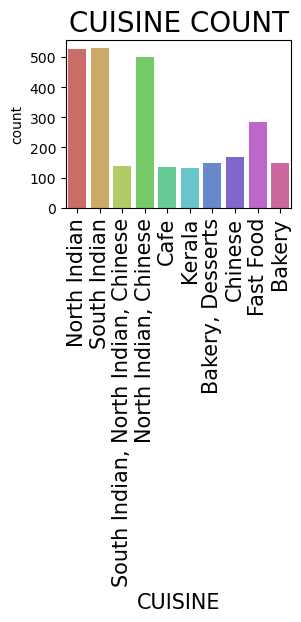

In [165]:
plt.figure(figsize=(20,30))
plt.subplot(2,2,1)
sns.countplot(x=df_train[df_train['CITY'].isin(df_train['CITY'].value_counts().head(10).index)]['CITY'],palette='hls',)
plt.title('CITY COUNT',fontsize=20)
plt.xlabel('CITY',fontsize=20)
plt.ylabel('COUNT',fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.subplot(2,2,2)
sns.countplot(x=df_train[df_train['LOCALITY'].isin(df_train['LOCALITY'].value_counts().head(10).index)]['LOCALITY'],palette='hls',)
plt.title('LOCALITY COUNT',fontsize=20)
plt.xlabel('LOCALITY',fontsize=15)
plt.ylabel('RATING',fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.subplot(2,2,3)
sns.countplot(x=df_train[df_train['TITLE'].isin(df_train['TITLE'].value_counts().head(10).index)]['TITLE'],palette='hls',)
plt.title('TITLE COUNT',fontsize=20)
plt.xlabel('TITLE',fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.show()
plt.subplot(2,2,4)
sns.countplot(x=df_train[df_train['CUISINES'].isin(df_train['CUISINES'].value_counts().head(10).index)]['CUISINES'],palette='hls',)
plt.title('CUISINE COUNT',fontsize=20)
plt.xlabel('CUISINE',fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.show()

City count is highest for Chennai followed by Bangalore. Tnagar followed by Gachibowli is the locality with more data.

Text(0.5, 0, 'Rating')

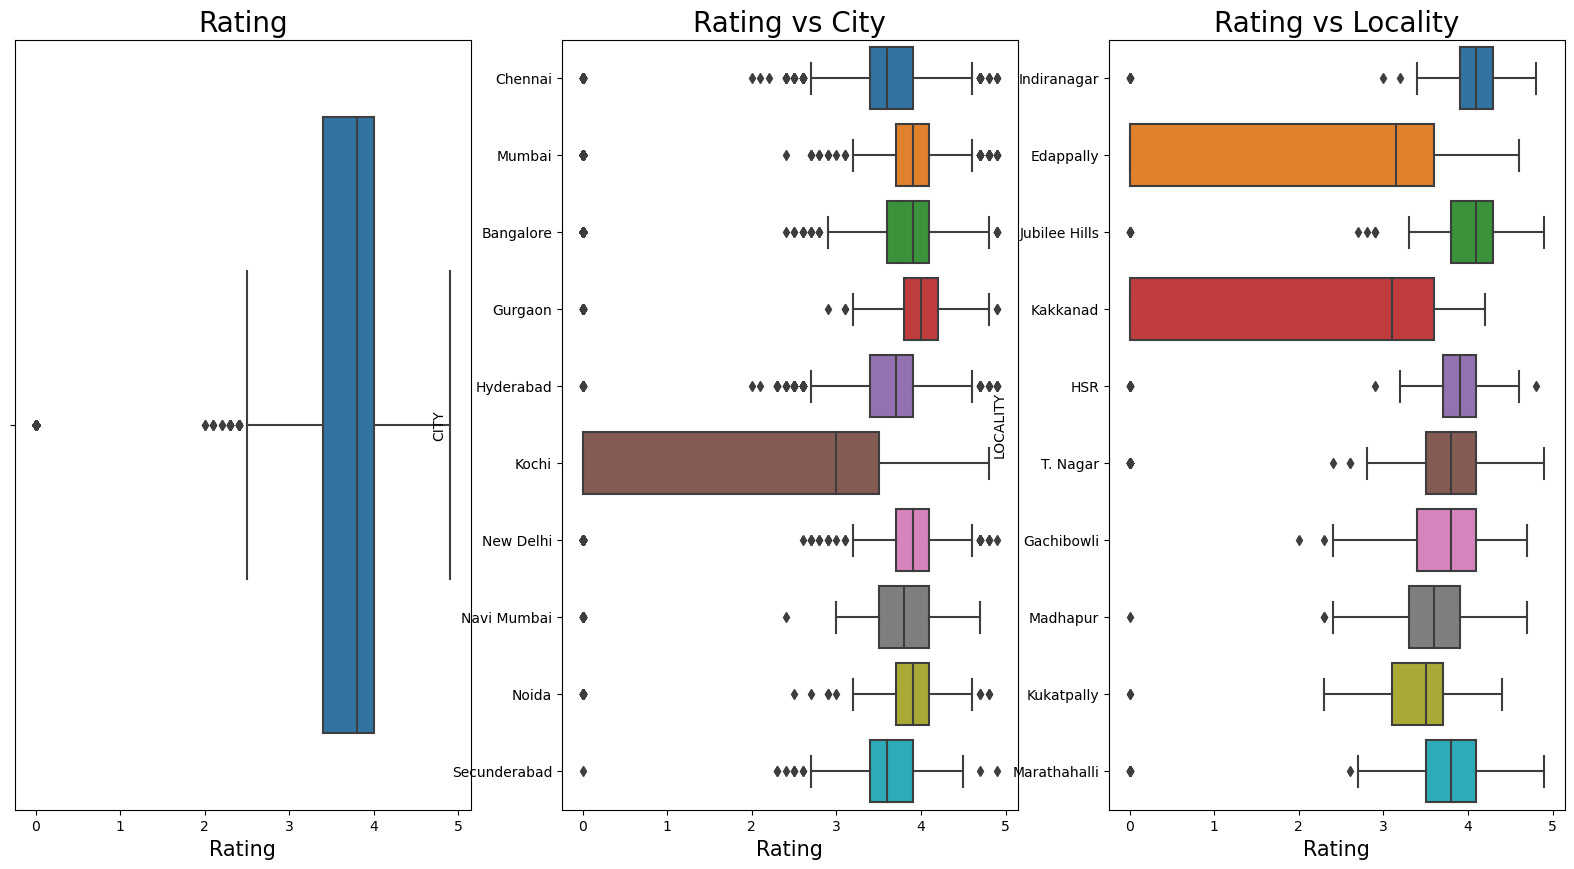

In [149]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.boxplot(x=df_train["RATING"])
plt.title('Rating',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.subplot(1,3,2)
sns.boxplot(x=df_train["RATING"],y=df_train[df_train['CITY'].isin(df_train['CITY'].value_counts().head(10).index)]['CITY'])
plt.title('Rating vs City',fontsize=20)
plt.xlabel('Rating',fontsize=15)
plt.subplot(1,3,3)
sns.boxplot(x=df_train["RATING"],y=df_train[df_train['LOCALITY'].isin(df_train['LOCALITY'].value_counts().head(10).index)]['LOCALITY'])
plt.title('Rating vs Locality',fontsize=20)
plt.xlabel('Rating',fontsize=15)

Average rating is 3.8 .Kochi s average rating is least 3 and Edapally and Kakkanad are the least rated locality.Indira Nagar and Jubilee mills are highly rated.

In [173]:
# Coverting the labels into a numeric form using Label Encoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df_train.columns:
    if df_train[col].dtype=='object':
        df_train[col]=le.fit_transform(df_train[col])

In [174]:
# storing the Dependent Variables in X and Independent Variable in Y
x=df_train.drop(['COST'],axis=1)
y=df_train['COST']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((8881, 8), (3807, 8), (8881,), (3807,))

In [169]:
a={'Model Name':[], 'Mean_Absolute_Error_MAE':[] ,'Adj_R_Square':[] ,'Root_Mean_Squared_Error_RMSE':[] ,'Mean_Absolute_Percentage_Error_MAPE':[] ,'Mean_Squared_Error_MSE':[] ,'Root_Mean_Squared_Log_Error_RMSLE':[] ,'R2_score':[]}
Results=pd.DataFrame(a)
Results.head()

,Model Name,Mean_Absolute_Error_MAE,Adj_R_Square,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score


In [170]:
# Build the Regression / Regressor models

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [171]:
# Create objects of Regression / Regressor models with default hyper-parameters

modelmlg = LinearRegression()
modeldcr = DecisionTreeRegressor()
modelbag = BaggingRegressor()
modelrfr = RandomForestRegressor()
modelSVR = SVR()
modelXGR = xgb.XGBRegressor()
modelKNN = KNeighborsRegressor(n_neighbors=5)
modelETR = ExtraTreesRegressor()
modelRE=Ridge()
modelLO=linear_model.Lasso(alpha=0.1)

modelGBR = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0,
                                     init=None, random_state=None, max_features=None,
                                     alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)

In [175]:
# Evalution matrix for all the algorithms

MM = [modelmlg, modeldcr, modelrfr, modelKNN, modelETR, modelGBR, modelXGR, modelbag,modelRE,modelLO]

for models in MM:
    
    # Fit the model with train data
    
    models.fit(x_train, y_train)
    
    # Predict the model with test data

    y_pred = models.predict(x_test)
    
    # Print the model name
    
    print('Model Name: ', models)
    
    # Evaluation metrics for Regression analysis
    from sklearn import metrics

    print('Mean Absolute Error (MAE):', round(metrics.mean_absolute_error(y_test, y_pred),3))  
    print('Mean Squared Error (MSE):', round(metrics.mean_squared_error(y_test, y_pred),3))  
    print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),3))
    print('R2_score:', round(metrics.r2_score(y_test, y_pred),6))
    print('Root Mean Squared Log Error (RMSLE):', round(np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),3))
    
    # Define the function to calculate the MAPE - Mean Absolute Percentage Error

    def MAPE (y_test, y_pred):
        y_test, y_pred = np.array(y_test), np.array(y_pred)
        return np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Evaluation of MAPE 
    result = MAPE(y_test, y_pred)
    print('Mean Absolute Percentage Error (MAPE):', round(result, 2), '%')
    
    # Calculate Adjusted R squared values 

    r_squared = round(metrics.r2_score(y_test, y_pred),6)
    adjusted_r_squared = round(1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1),6)
    print('Adj R Square: ', adjusted_r_squared)
    print('------------------------------------------------------------------------------------------------------------')
    new_row = {'Model Name' : models,
               'Mean_Absolute_Error_MAE' : metrics.mean_absolute_error(y_test, y_pred),
               'Adj_R_Square' : adjusted_r_squared,
               'Root_Mean_Squared_Error_RMSE' : np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
               'Mean_Absolute_Percentage_Error_MAPE' : result,
               'Mean_Squared_Error_MSE' : metrics.mean_squared_error(y_test, y_pred),
               'Root_Mean_Squared_Log_Error_RMSLE': np.log(np.sqrt(metrics.mean_squared_error(y_test, y_pred))),
               'R2_score' : metrics.r2_score(y_test, y_pred)}
    Results = Results.append(new_row, ignore_index=True)
    #------------------------------------------------------------

Model Name:  LinearRegression()
Mean Absolute Error (MAE): 330.903
Mean Squared Error (MSE): 284277.98
Root Mean Squared Error (RMSE): 533.177
R2_score: 0.172151
Root Mean Squared Log Error (RMSLE): 6.279
Mean Absolute Percentage Error (MAPE): 75.73 %
Adj R Square:  0.171629
------------------------------------------------------------------------------------------------------------
Model Name:  DecisionTreeRegressor()
Mean Absolute Error (MAE): 251.107
Mean Squared Error (MSE): 224529.806
Root Mean Squared Error (RMSE): 473.846
R2_score: 0.346144
Root Mean Squared Log Error (RMSLE): 6.161
Mean Absolute Percentage Error (MAPE): 46.32 %
Adj R Square:  0.345731
------------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)


Model Name:  RandomForestRegressor()
Mean Absolute Error (MAE): 179.149
Mean Squared Error (MSE): 85750.199
Root Mean Squared Error (RMSE): 292.831
R2_score: 0.750286
Root Mean Squared Log Error (RMSLE): 5.68
Mean Absolute Percentage Error (MAPE): 35.04 %
Adj R Square:  0.750128
------------------------------------------------------------------------------------------------------------
Model Name:  KNeighborsRegressor()
Mean Absolute Error (MAE): 352.447
Mean Squared Error (MSE): 325350.381
Root Mean Squared Error (RMSE): 570.395
R2_score: 0.052544
Root Mean Squared Log Error (RMSLE): 6.346
Mean Absolute Percentage Error (MAPE): 75.73 %
Adj R Square:  0.051946
------------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)


Model Name:  ExtraTreesRegressor()
Mean Absolute Error (MAE): 185.359
Mean Squared Error (MSE): 86856.015
Root Mean Squared Error (RMSE): 294.713
R2_score: 0.747066
Root Mean Squared Log Error (RMSLE): 5.686
Mean Absolute Percentage Error (MAPE): 38.42 %
Adj R Square:  0.746906
------------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)


Model Name:  GradientBoostingRegressor()
Mean Absolute Error (MAE): 194.047
Mean Squared Error (MSE): 94786.005
Root Mean Squared Error (RMSE): 307.873
R2_score: 0.723973
Root Mean Squared Log Error (RMSLE): 5.73
Mean Absolute Percentage Error (MAPE): 40.49 %
Adj R Square:  0.723799
------------------------------------------------------------------------------------------------------------
Model Name:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, m

C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)


Model Name:  BaggingRegressor()
Mean Absolute Error (MAE): 190.53
Mean Squared Error (MSE): 97447.441
Root Mean Squared Error (RMSE): 312.166
R2_score: 0.716222
Root Mean Squared Log Error (RMSLE): 5.744
Mean Absolute Percentage Error (MAPE): 36.77 %
Adj R Square:  0.716043
------------------------------------------------------------------------------------------------------------
Model Name:  Ridge()
Mean Absolute Error (MAE): 330.901
Mean Squared Error (MSE): 284277.663
Root Mean Squared Error (RMSE): 533.177
R2_score: 0.172152
Root Mean Squared Log Error (RMSLE): 6.279
Mean Absolute Percentage Error (MAPE): 75.73 %
Adj R Square:  0.17163
------------------------------------------------------------------------------------------------------------
Model Name:  Lasso(alpha=0.1)
Mean Absolute Error (MAE): 330.887
Mean Squared Error (MSE): 284275.204
Root Mean Squared Error (RMSE): 533.175
R2_score: 0.172159
Root Mean Squared Log Error (RMSLE): 6.279
Mean Absolute Percentage Error (MAPE):

C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)
C:\Users\User\AppData\Local\Temp\ipykernel_22376\99501362.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results = Results.append(new_row, ignore_index=True)


In [176]:
models=['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','KNeighborsRegressor','ExtraTreesRegressor','GradientBoostingRegressor','XGBRegressor','BaggingRegressor','Ridge Regression','Lasso Regression']
result=pd.DataFrame({'Model_Name':models})
result['Adj_R_Square']=Results['Adj_R_Square']
result['Mean_Absolute_Error_MAE']=Results['Mean_Absolute_Error_MAE']
result['Root_Mean_Squared_Error_RMSE']=Results['Root_Mean_Squared_Error_RMSE']
result['Mean_Absolute_Percentage_Error_MAPE']=Results['Mean_Absolute_Percentage_Error_MAPE']
result['Mean_Squared_Error_MSE']=Results['Mean_Squared_Error_MSE']
result['Root_Mean_Squared_Log_Error_RMSLE']=Results['Root_Mean_Squared_Log_Error_RMSLE']
result['R2_score']=Results['R2_score']
result=result.sort_values(by='Adj_R_Square',ascending=False).reset_index(drop=True)
result

,Model_Name,Adj_R_Square,Mean_Absolute_Error_MAE,Root_Mean_Squared_Error_RMSE,Mean_Absolute_Percentage_Error_MAPE,Mean_Squared_Error_MSE,Root_Mean_Squared_Log_Error_RMSLE,R2_score
0,RandomForestRegressor,0.750128,179.149325,292.831349,35.036905,85750.198871,5.679597,0.750286
1,ExtraTreesRegressor,0.746906,185.359167,294.713446,38.418705,86856.015291,5.686004,0.747066
2,XGBRegressor,0.733981,187.242211,302.145006,36.944821,91291.604896,5.710907,0.734149
3,GradientBoostingRegressor,0.723799,194.046697,307.873358,40.487438,94786.004685,5.729689,0.723973
4,BaggingRegressor,0.716043,190.529630,312.165726,36.771322,97447.440780,5.743534,0.716222
5,DecisionTreeRegressor,0.345731,251.106646,473.845762,46.323392,224529.805884,6.160882,0.346144
6,Lasso Regression,0.171637,330.886723,533.174647,75.727031,284275.204327,6.278849,0.172159
7,Ridge Regression,0.171630,330.901397,533.176953,75.730869,284277.663340,6.278853,0.172152
8,LinearRegression,0.171629,330.903335,533.177250,75.731384,284277.979561,6.278854,0.172151
9,KNeighborsRegressor,0.051946,352.447071,570.394935,75.726466,325350.381424,6.346329,0.052544


RandomForestRegressor is the best model with highest R2 score . Let us test it with Test Data

Test Data

In [187]:
df_test=pd.read_excel('C:\\Users\\User\\Downloads\\Untitled Folder\\Data_Test.xlsx')
df_test.head()
# Changing the city to max repeating one.
df_test['CITY']=df_test['CITY'].fillna(df_test['CITY'].mode()[0])
# Changing the locality to max repeating one in max city
df_test['LOCALITY']=df_test['LOCALITY'].fillna(df_test[df_test['CITY']==df_test['CITY'].mode()[0]]['LOCALITY'].mode()[0])
# Dropping the NA  Ratings
df_test['RATING'].fillna('0',inplace=True)
df_test['RATING'].replace({'NEW':'0','-':'0'},inplace=True)
df_test['RATING']=df_test['RATING'].apply(lambda x: float(x))
df_test['RATING'].replace({0:math.ceil(df_test['RATING'].mean())},inplace=True)
df_test['VOTES'].fillna('0',inplace=True)
df_test['VOTES']=df_test['VOTES'].apply(lambda x: float(re.findall('[0-9]+',x)[0]))
df_test['VOTES'].replace({0:math.ceil(df_test['VOTES'].mean())},inplace=True)
df_test['TITLE'].replace({'None':df_test['TITLE'].mode()[0]},inplace=True)

In [188]:
le=LabelEncoder()
for col in df_test.columns:
    if df_test[col].dtype=='object':
        df_test[col]=le.fit_transform(df_test[col])

In [189]:
# Predict the model with test data
y_pred_test = modelETR.predict(df_test)

In [184]:
df_test['COST']=y_pred_test
df_test.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,23,4085,1293,503,110,662,4.3,564.0,1030.5
1,74,12680,1632,933,96,221,4.2,61.0,1684.5
2,23,1411,1455,219,96,411,3.8,350.0,605.5
3,74,204,208,1071,41,456,3.8,1445.0,1492.0
4,74,13453,1637,208,78,300,3.6,23.0,1065.0


In [191]:
df_file=pd.read_excel('C:\\Users\\User\\Downloads\\Untitled Folder\\Data_Test.xlsx')
df_file['COST']=y_pred_test
df_file.to_csv('final_prediction_file_rc.csv',index=False)